In [32]:
import sys
sys.path.append("../")

In [33]:
import random

INTERVAL_LOW = 0
INTERVAL_HIGH = 5
SAMPLES = int(1e5)

a = -0.1
b = 2
c = -2
d = -0.1
normalization_factor = 1

def system(y, t,a,b,c,d):
    x, y = y   
    dXdt = (a* x**3 + b* y **2) * y
    dYdt = c * x**3 + d* y **3 + 0.001 * x
    return dXdt, dYdt

def get_time_norm_function(function, max_time):
    def function_norm_time(t):
        return function(t * max_time)

    return function_norm_time


def initial_conditions(number_of_initial_conditions):
    def generate_initial_conditions():
        x = random.uniform(-2,2)
        y = random.uniform(-2,2)
        return  [x,y]
    
    yield [0.5,-0.5]
    for i in range(number_of_initial_conditions -1):  
        yield generate_initial_conditions()

include_time = False
# The ideal trained neural network model
class ExactModel:
    def eval_model(self, X):
        if include_time:
            return [(a * (X[1]* normalization_factor ) ** 3 + b * (X[2]* normalization_factor  )**2 ) * (X[2]* normalization_factor)]
        else:
            return [(a * (X[0]* normalization_factor ) ** 3 + b * (X[1]* normalization_factor  )**2 ) * (X[1]* normalization_factor)]

#         if include_time:
#             return [c* (X[1]*normalization_factor) **3 + d * (X[2]*normalization_factor)**3 + 0.001 * X[1]*normalization_factor]
#         else:     
#             return [c* (X[0]*normalization_factor) **3 + d * (X[1]*normalization_factor)**3 + 0.001 * X[0]*normalization_factor]
       
           

exact = ExactModel()

Generating training data...
[0.5, -0.5]
[-0.9465660954243438, 1.0148779136414938]
[0.6350339674499432, -0.7199158590369525]
[0.5781787961790834, -0.6787116544226861]
[-1.7086084863797777, 1.2071696339976348]
[0.2697868238374186, 0.5654212366194469]
[-1.441501539453463, -1.1536988880660068]
[0.2799049414491641, 1.9247039715081806]
[-0.4773974537223551, 1.5050027024675594]
[1.7748329355056285, -1.2536030573086276]
[-0.6350652975864235, -1.0265583902532622]
[-0.14584573500875653, -1.2316039987246787]
[-0.5930698871861617, 1.9342293593388913]
[0.05701901756933747, -1.3344360181522497]
[-0.6531819904145055, 0.6325897479594413]
[-1.9307026340041649, 0.49090784958025546]
[1.9817347203533013, 1.3060600902693547]
[1.7908246127814849, -0.4499588478395937]
[1.8600411609453276, 0.4579965005637088]
[-0.7946033822378715, -1.353581172913922]
[0.8085261334286815, 0.5521394010907557]
[-1.4663048084812345, -1.6169915487804905]
[-1.0769495643278275, 0.2603944618137959]
[-1.0337028364373926, 1.98907931692

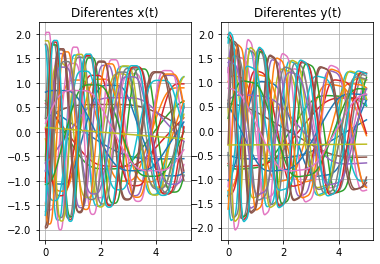

In [34]:
from interpolation.interpolate_system import odeint_interpolate
from interpolation.regression_dataset import RegressionDataset

import matplotlib.pyplot as plt
import numpy as np


number_of_systems = 30
samples_per_system = 10000

dataset_train = None
dataset_test = None


print("Generating training data...")
f, axes = plt.subplots(1, 2)

for init_conditions in initial_conditions(number_of_systems):
    print(init_conditions)
    # Interpola el sistema tomando muestras en un intervalo uniforme
    y_inter = odeint_interpolate( system, init_conditions, INTERVAL_LOW, INTERVAL_HIGH, 10000, (a,b,c,d))
    # Normaliza con respecto al tiempo las funciones obtenidas 
    y_inter_time_norm = [get_time_norm_function(yi, INTERVAL_HIGH) for yi in y_inter]
    
    t = np.linspace(INTERVAL_LOW, INTERVAL_HIGH, 10000)
    X,Y = y_inter

    axes[0].plot(t, [X(ti) for ti in t])
    axes[1].plot(t, [Y(ti) for ti in t])
    
    
    def y_prime(t):
        return (a* y_inter_time_norm[0](t)**3 + b*y_inter_time_norm[1](t) **2) * y_inter_time_norm[1](t) 
#         return c * y_inter_time_norm[0](t)**3 + d * y_inter_time_norm[1](t) **3 + 0.001 * y_inter_time_norm[0](t)
    
    d_train = RegressionDataset(y_inter_time_norm, y_prime, normalization_factor, samples_per_system * 80 // 100, include_time)
    d_test = RegressionDataset(y_inter_time_norm, y_prime, normalization_factor, samples_per_system * 20 // 100, include_time)
   
    if dataset_train:
        dataset_train.concat_dataset(d_train)
        dataset_test.concat_dataset(d_test)
    else:
        dataset_train = d_train
        dataset_test = d_test




print("Done")
axes[0].grid()
axes[1].grid()
axes[0].set_title("Diferentes x(t)")
axes[1].set_title("Diferentes y(t)")
plt.show()

In [20]:
%load_ext autoreload
%autoreload 2
from interpolation.regression_nn import RegressionNN
m1 = RegressionNN.nn_dataset_regression(dataset_train, dataset_test,1000,50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
epoch: 0
train_loss: 1.032154600828245
test_loss: 0.026954045018952866
epoch: 10
train_loss: 0.004113241854304421
test_loss: 0.010199365123964322
epoch: 20
train_loss: 0.03674454440924853
test_loss: 0.021046654364757965
epoch: 30
train_loss: 0.0139080316896105
test_loss: 0.005252061502532152
epoch: 40
train_loss: 0.0032737003978928134
test_loss: 0.003172655264669747
train_loss: 0.012820560408279936
test_loss: 0.009886819292694785


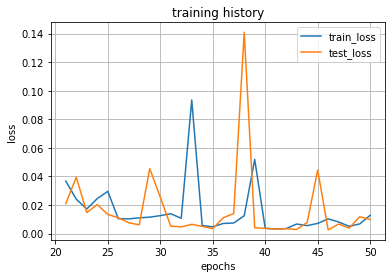

In [35]:
m1.plot_learn_history(20,50)

In [36]:
y_inter = odeint_interpolate( system, [0.5, -0.5], INTERVAL_LOW, INTERVAL_HIGH, 10000, (a,b,c,d) )
y_inter_time_norm = [get_time_norm_function(yi, INTERVAL_HIGH) for yi in y_inter]

In [37]:
%load_ext autoreload
%autoreload 2
from query_set.check_var_exist import check_var_exist_grad_dataset
# import math 

# def rmsValue(arr, n):
#     square = 0
#     mean = 0.0
#     root = 0.0
     
#     #Calculate square
#     for i in range(0,n):
#         square += (arr[i]**2)
     
#     #Calculate Mean
#     mean = (square / (float)(n))
     
#     #Calculate Root
#     root = math.sqrt(mean)
     
#     return root


# n = min(100000, len(dataset_train.X))
# values = check_var_exist_grad_dataset(m1, 0, dataset_train)
# print(rmsValue(values, n))


values = check_var_exist_grad_dataset(m1, 0, dataset_train)
avr = sum(values)/len(values)
print(avr)


values = check_var_exist_grad_dataset(m1, 1, dataset_train)
avr = sum(values)/len(values)
print(avr)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.20272585838618054
6.2968557127678055


In [38]:
%load_ext autoreload
%autoreload 2
from query_set.regression_dependency import check_polynomial_dependency

result = check_polynomial_dependency(
        m1,
        0,
        y_inter_time_norm,
        0.4,
        0.6,
        3,
        normalization_factor,
        0.5,
        1000,
        include_time)

print(result)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'polynomial': [0.00824022478212041, 0.004515534476155208, 0.06558200330540148, 0.28734308255095115], 'determination': 0.9999999999991342}


In [39]:
%load_ext autoreload
%autoreload 2
from query_set.regression_dependency import check_polynomial_dependency

result = check_polynomial_dependency(
        m1,
        1,
        y_inter_time_norm,
        0.4,
        0.5,
        3,
        normalization_factor,
        0.5,
        1000,
        include_time)

print(result)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'polynomial': [1.3923054683571947, 0.03928352992035406, 0.09387271605005684, 0.012407890772864985], 'determination': 0.9999983392727523}
